# Complete The Look (CTL)

Data Exploration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import heapq
import json
import numpy
import os
import pickle
import random
from tqdm import tqdm
import tensorflow as tf

from PIL import Image, ImageDraw, ImageFont
import requests
from io import BytesIO

%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/anaconda/envs/py37_tensorflow/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
data_dir = "/recsys_data/RecSys/fashion/STL-Dataset"

fashion_data = []
with open(os.path.join(data_dir, "fashion.json"), 'r') as fr:
    for line in fr:
        fashion_data.append(json.loads(line.strip()))


In [4]:
def view_data(example):
    product_url = convert_to_url(example['product'])
    scene_url = convert_to_url(example['scene'])
    bb = example["bbox"]
    
    response = requests.get(product_url)
    img_product = Image.open(BytesIO(response.content))
    
    response = requests.get(scene_url)
    img_scene = Image.open(BytesIO(response.content))
    h, w = img_scene.height, img_scene.width
#     bbox = [(int(bb[0]*h), int(bb[1]*w)), (int(bb[2]*h), int(bb[3]*w))]
    bbox = [(int(bb[0]*w), int(bb[1]*h)), (int(bb[2]*w), int(bb[3]*h))]
    print(h, w, bbox)

    figure, axis = plt.subplots(1, 2, figsize=(10,5))
    img1 = ImageDraw.Draw(img_scene)  
    img1.rectangle(bbox, outline ="red")
    imgplot = axis[0].imshow(img_scene)
#     img_scene.show()

#     draw = ImageDraw.Draw(img_scene)
#     draw.rectangle(bbox, outline='yellow', width=5)
#     axis[0].axis('off')

    imgplot = axis[1].imshow(img_product)
    axis[1].axis('off')
    plt.show()
    
    return img_product, img_scene
    
def convert_to_url(signature):
    prefix = 'http://i.pinimg.com/400x/%s/%s/%s/%s.jpg'
    return prefix % (signature[0:2], signature[2:4], signature[4:6], signature)

503 400 [(218, 343), (281, 400)]


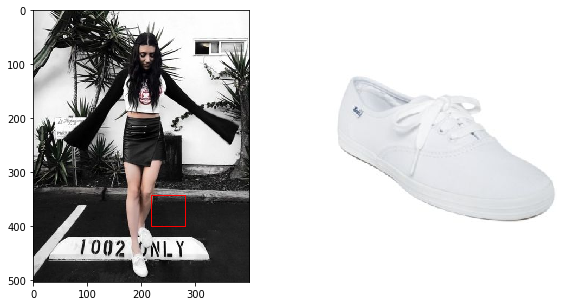

In [5]:
img_p, img_s = view_data(fashion_data[0])

In [33]:
fashion_data[0]

{'product': '0027e30879ce3d87f82f699f148bff7e',
 'scene': 'cdab9160072dd1800038227960ff6467',
 'bbox': [0.434097, 0.859363, 0.560254, 1.0]}

In [10]:
len(fashion_data)

72198

In [39]:
img_s.height

503